# Initial data analysis and Linear Regression

This assignment is dedicated to Linear regression. By focusing on prediction different features of football players you understand the mathematics behind it and see the usefulness of main data analysis libraries.

**Materials**
- [Documentation](http://docs.scipy.org/doc/) libraries Numpy and SciPy
- [Documentation](http://matplotlib.org/) library Matplotlib 
- [Documentation](http://pandas.pydata.org/pandas-docs/stable/tutorials.html) library Pandas
- [Pandas Cheat Sheet](http://www.analyticsvidhya.com/blog/2015/07/11-steps-perform-data-analysis-pandas-python/)
- [Documentation](http://stanford.edu/~mwaskom/software/seaborn/) library Seaborn 

**Resources**
- In this notebook we will use *FIFA 19 complete player dataset* which is taken from [here](https://www.kaggle.com/karangadiya/fifa19)

## Part 1. Initial data analysis with Pandas

Importing libraries.

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random

%matplotlib inline

Load the data. Table *data.csv* should be in the same directory as this notebook.

In [ ]:
data = pd.read_csv("data.csv", index_col='ID')

The first thing you need to do with a dataframe after loading is to look at first few records. This way you can make sure that you have parsed it correctly. Moreover, you can get acquainted with the data, look at the features and their type (categorical, numerical, text ...).

They you may check whether the data has missing values inside. Depending on the problem type and percentage of missing values you can either fill them with some value or drop columns/rows having null values.

After that you may want to look closer at some features. You can draw a histogram for defining a feature distribution (normal, power or some other). Also with the help of histogram you can find values which are really differ from the rest, we call them **outliers**. Histograms can be plotted by *hist* method of Pandas DataFrame.

**Example 1** Let's look at first 5 rows of data using method *head* for DataFrame data.

In [ ]:
data.head()

Unfortunately the number of columns exceeds the maximum visible default value in Pandas. Use the magic line above to remove this restriction.

In [ ]:
pd.set_option('display.max_columns', None)

In [ ]:
data.head()

Much better now.

**Example 2** Print total player number and top-10 columns containing the most number of null values.

In [ ]:
print(f"Total number of players in dataset {data.shape[0]}")

In [ ]:
from tabulate import tabulate

top = 10
print(tabulate(
    sorted(list(zip(data.columns, data.isnull().sum(), data.isnull().sum() / data.shape[0] * 100)), key=lambda x: -x[2])[:top], 
    headers=['col_name', 'null_cnt', 'null_perc']))

**Example 3**. Let's built a histogram of weight distribution in kgs from footbal players data. Follow steps:
- Extract weight value from string (column Weight).
- Convert *Weight* column to float type.
- Get rid of null values in weight column, use median column value instead of them.
- Convert pounds to kilograms
- Finally use method *hist* for DataFrame *data* with arguments *column=Weight* (we look at this feature distribution)

In [ ]:
print(f"Weight column type is '{data['Weight'].dtype}'")

In [ ]:
data['Weight_float'] = data['Weight'].str.extract(r'([0-9]+)lbs').astype(float)
data['Weight_float'].fillna(data['Weight_float'].median())
POUND_TO_KILO = 0.454
data['Weight_kg'] = data.apply(lambda row: row['Weight_float'] * POUND_TO_KILO, axis=1)
data.hist(column='Weight_kg', bins=30)
plt.show()

**Task 1 (1 point)**. Built a histogram of the height distribution in *meters* from footbal player data. Remember that height is in format *feet* '*inches*.  Instead of filling null values with some constant just drop them. Use *.dropna* for specified column.

In [ ]:
# Your code here

Effective way to visualize the relationship between two features is to draw a simple _scatter plot_. The position of each dot on the horizontal and vertical axis indicates values for an individual data point.

**Example 4.** Visualize the dependence of _Strength_  on _Weight_kg_.

In [ ]:
data.plot.scatter(x='Weight_kg', y='Strength')
plt.title('Dependence of strength on weight')
plt.show()

One more effective way of initial data analysis is to plot pairwise feature dependencies. That simply combines already considered Scatter plot and a histogram. We create $m \times m$ plots (_m_ is number of features) where pictures on diagonal represent **histograms** and outside the diagonal **scatter_matrix**. That can be done with the help of _scatter_matrix_ Pandas DataFrame method or _pairplot_ in Seaborn.

**Example 5.**
Illustrate pairwise dependencies between _ShortPassing_, _Dribbling_, _BallControl_ and _Strength_ features of footbal players.

In [ ]:
sns.pairplot(data[['ShortPassing', 'Dribbling', 'BallControl', 'Strength']])

Histograms and scatter plots are good for continuous (numerical) features. Distribution of data by categorical features (that have a fixed number of possible values) can be represented with **bar charts**.

**Example 6.** Show distribution of players by age groups (under 20 yo. _young_, between 20-30 _mature_, over 30 yo. _masters_)

In [ ]:
data['age_group'] = data.apply(lambda x: 'young' if x['Age'] < 20 else 'mature' if x['Age'] <= 30 else 'masters', axis=1)
distr = data.groupby('age_group').count().max(axis=1)[['young', 'mature', 'masters']]

plt.bar(distr.index, distr.values)
plt.ylabel('Number of players')
plt.title('Distribution of players across age groups')
plt.show()

Really often it is necessary to explore the distribution of some numerical feature based on the value of categorical one. Here comes the _boxplot_ of Seaborn library, which can show statistics of numerical features (mean, quantiles) by different value of categorical feature. Boxplot can also help to detect **outliers** - values that significantly differ from the rest. More detailed explanation [here](https://towardsdatascience.com/understanding-boxplots-5e2df7bcbd51).

**Example 7.** Show _SprintSpeed_ statistics across different age groups.

_Hint_: in order to prevent printing the service information and make our pictures more attractive we can write `;` in the end of last line.

In [ ]:
sns.boxplot(x='age_group', y='SprintSpeed', data=data);

## Part 2. Minimizing Mean Squared Error. Linear Regression

We are going to predict target numerical variable $y$ for _n_ samples with the help of $x_1, x_2, ..., x_m$ _m_ features under the assumption of _liner dependence_ existence between features and target, i.e.
$$\hat{y} = w_0 + w_1 * x_1 + w_2 * x_2 + ... + w_m * x_m$$
so that Mean Squared Error between $y$ and $\hat{y}$ was the lowest possible
$$MSE = \frac{1}{n}\sum_{i=1}^n {(y_i - \hat{y})}^2 -> min_{w_0, w_1, w_2, ...w_m}$$
where $w_0$ is "free" weight component called **intercept** and $(w_1, w_2, ... w_n)$ is a **vector of coefficients**.

 ### Part 2.1 Linear Regression with one variable

Just to understand the basic principles, let's try to predict _BallControl_ score based on the _Dribbling_ score for every player. Simple Linear Regression with one feature.
$$BallControl = w_0 + w_1 * Dribbling$$

We are going to do real data science, aren't we? So let us split the available data into train and test samples. We let our model see only the train data, then we can measure it's quality on test sample.

In [ ]:
from sklearn.model_selection import train_test_split

data.fillna({'BallControl': data['BallControl'].mean(), 'Dribbling': data['Dribbling'].mean()}, inplace=True)
X_train, X_test, y_train, y_test = train_test_split(data['Dribbling'].values, data['BallControl'].values, train_size=0.8)
X_train = X_train.reshape(-1, 1)
X_test = X_test.reshape(-1, 1)

To illustrate the approach, let's use Ridge model from sklearn with _regularization_ param alpha=0. What does it mean and what it if for we will find out later on in this course. But for now I require avoiding regularization by setting regularization param to zero.

In [ ]:
from sklearn.linear_model import Ridge

lr = Ridge(alpha=0)
lr.fit(X=X_train, y=y_train)

In [ ]:
print(f'w_0 = {lr.intercept_}, w_1 = {lr.coef_[0]}')

In [ ]:
y_pred_train = lr.predict(X_train)
y_pred_test = lr.predict(X_test)

In [ ]:
data['predicted_BallControl'] = lr.predict(data['Dribbling'].values.reshape(-1, 1))
data[['Name', 'Dribbling', 'BallControl', 'predicted_BallControl']].head()

Right now we have predictions for train and test samples. How about measure the quality of the model?

**Task 2 (0.5 point).** Write your own function for MSE calculation using the formula above. Calculate train and test MSE, compare to built-in method (_sklearn.metrics.mean_squared_error_)

In [ ]:
def mse(y_true, y_pred):
    error = # your code here
    return error

In [ ]:
from sklearn.metrics import mean_squared_error

assert round(mean_squared_error(y_train, y_pred_train), 9) == round(mse(y_train, y_pred_train), 9)
assert round(mean_squared_error(y_test, y_pred_test), 9) == round(mse(y_test, y_pred_test), 9)

In [ ]:
print(f'Train MSE {mse(y_train, y_pred_train)}, test MSE {mse(y_test, y_pred_test)}')

**Task 3 (1.5 points).** Visualize the dependence of **test** _BallControl_ predictions and real _BallControl_ score on _Dribbling_ score. Don't forget to add axis and plot names!

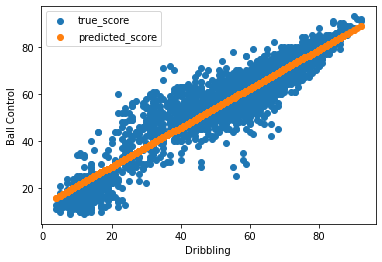

In [75]:
# Your code here

### Part 2.2 Linear regression with many variables

**Task 4 (5 points).** Implement your own Linear Regression class for any number of input features and settable boolean parameter *fit_intercept*.

In this task you will work with _optimize_ module of [_scipy_](https://docs.scipy.org/doc/scipy/reference/) open-source library for mathematics, science, and engineering. You will need a function [_least_squares_](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html) that finds a coefficients for linear regression by minimizing the sum of the squares of the residuals (which is equivalent to MSE minimizing). More information about least squares approach [here](https://en.wikipedia.org/wiki/Least_squares). <br><br>
Even though this function has many parameters, you need only a few of them to complete the task (the rest will be filled in with default values automatically).
- **fun** computes a vector of residuals given weights, features and target, we provide you a function template _compute_residuals_
- **x0** this is an initial weights vector. You can either pass a vector of zeros[n_features] or fill in randomly.
- **args** are fixed arguments to _fun_ function (which we are not going to optimize). In that particular case you will need to pass X and y.


You can access optimized weights by accessing the field **.x** of object which returns by this function.

!!! IMPORTANT <br>
Please complete this assignment **without any cycles**. You may use the standard operations of matrix \ vector multiplication ans different statistic calculation with NumPy. Otherwise, your solution may not go through asserts.

In [ ]:
def compute_residuals(w, X, y):
    """
    Compute residuals when predicting y_hat as matrix product of X and transposed w
    :param w: linear regression weights, numpy.ndarrya: float64[num_features]
    :param X: training features, numpy.ndarray: float64[num_samples, num_features]
    :param y: training target, numpy.ndarray: float64[num_samples]
    :returns: vector of residuals (y_i_hat - y_i) for each sample_i in X
    
    """
    residuals = # Your code here
    return residuals

In [ ]:
from sklearn.base import BaseEstimator
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from scipy.optimize import least_squares

class LinearRegression(BaseEstimator):
    def __init__(self, fit_intercept=True):
        self.fit_intercept = fit_intercept
    
    def fit(self, X, y):
        """
        fit model weights given input features and target
        :param X: training features, numpy.ndarray: numeric[num_samples, num_features]
        :param y: training target, numpy.ndarray: numeric[num_samples]
        :returns: linear predictor with fitted weights so that train MSE is the lowest possible
        :note: weights: numpy.ndarray: float64[num_features] stored as class field

        """
        
        # Check that X and y have correct shape
        X, y = check_X_y(X, y)
        
        # Save train data information. Necessary for following the uniform API
        self.X_ = X
        self.y_ = y
        self.n_features_in_ = X.shape[1]
        
        # Copy arrays and cast them to uniform type
        X_train = X.astype('float64')
        y_train = y.astype('float64')
        
        # Add dummy column of ones to X_train if we want to train an intercept - last component of future weight vector
        if self.fit_intercept:
            X_train = np.column_stack((X_train, np.ones(X_train.shape[0])))
        
        # Your code here.
        # Just follow the suggested steps: create initial weights vector,
        # apply least_squares optimizer passing the parameters described above
        # and finally extract optimized weights.
        # Remember: you need to distinguish coefficients from intercept when fit_intercept=True
        self.coef_ = 
        self.intercept_ = 
        
        # Return the classifier
        return self
        
    def predict(self, X):
        # Check is fit had been called
        check_is_fitted(self)
        
        # Input validation
        X = check_array(X)
        
        return X.dot(self.coef_) + self.intercept_

In [ ]:
#Testing area
from sklearn.utils.estimator_checks import check_estimator
from sklearn.linear_model import Ridge

lr = LinearRegression()
ridge = Ridge(alpha=0)
lr_no_intercept = LinearRegression(fit_intercept=False)
ridge_no_intercept = Ridge(alpha=0, fit_intercept=False)

#Check compatibility with Sklearn framework and apply some spesific internal tests
check_estimator(lr)
check_estimator(lr_no_intercept)

#Compare model accuracy with Ridge(0) from Sklearn
data.fillna({'BallControl': data['BallControl'].mean()
             , 'Dribbling': data['Dribbling'].mean()
             , 'Strength': data['Strength'].mean()}, inplace=True)
X_sample, y_sample = data[['Dribbling', 'Strength']], data['BallControl']
lr.fit(X_sample, y_sample)
ridge.fit(X_sample, y_sample)
assert np.allclose(lr.predict(X_sample), ridge.predict(X_sample), rtol=1e-03), "Your model with intercept not accurate enough!"
lr_no_intercept.fit(X_sample, y_sample)
ridge_no_intercept.fit(X_sample, y_sample)
assert np.allclose(lr_no_intercept.predict(X_sample), ridge_no_intercept.predict(X_sample), rtol=1e-03), "Your model without intercept not accurate enough!"

Let's add more features in order to predict Dribbling score more accurately.

In [ ]:
features = ['BallControl', 'ShortPassing', 'Strength', 'Weight_float', 'Weight_kg']
target = 'Dribbling'
for feat in features:
    data.fillna({feat: data[feat].mean()}, inplace=True)
X_train, X_test, y_train, y_test = train_test_split(data[features].values, data[target].values, train_size=0.8, random_state=2)

In [ ]:
lr = Ridge(0)
lr.fit(X=X_train, y=y_train)

y_pred_train = lr.predict(X_train)
y_pred_test = lr.predict(X_test)

print(f'Train MSE {mean_squared_error(y_train, y_pred_train)}, test MSE {mean_squared_error(y_test, y_pred_test)}')

In [ ]:
print(f'w_0 = {lr.intercept_}, w_1, w_2, w_3, w_4, w_5 = {lr.coef_}')

That is not ok, two last weight components are too large, and they vary depending on the run! Although the result seems better our model would behave unexpectadly to the patterns in data it has never seen! Large weights and weights instability are the sign of [**overfitting**](https://en.wikipedia.org/wiki/Overfitting).  <br><br>
According to the definition it is "_the production of an analysis that corresponds too closely or exactly to a particular set of data, and may therefore fail to fit additional data or predict future observations reliably_". But what does it actually mean?

Assume that we have a player whose weight in kg was calculated with some tiny error, let's say +=1g.

In [ ]:
player = data[features + [target]].iloc[0:2]
player['Predicted_dribbling'] = lr.predict(player[features].values)
player.head()

Predictions are pretty good if the data is _pure_. Let's add some noise to _Weight_kg_ feature:

In [ ]:
player['Weight_kg'] = player['Weight_kg'] + [-0.001, 0.001]
player['Predicted_dribbling_with_error'] = lr.predict(player[features].values)
player.head()

Predicted dribbling value has changed significantly! Look at how this tiny **1g** error leads to extremly big or small dribbling!

The reason behind it is strange unstable behaviour is **collinearity** between Weight and Weight_kg features, what means that Weight_kg can be linearly predicted from Weight. As a matter of fact they represent the same essense but in different scales. <br><br>
**Multicollinearity** describes a more general case, when one feature can be predicted by linear combination of some other features.<br><br>
Collinearity is really close related to **correlation** - degree to which a pair of variables are linearly related. Collinearity origins from Linear Algebra and Geometry whereas Correlation is a term from Statistics. Anyway all of this three terms refer to **linearly dependent features**, which is really bad for Linear Models.

But why it is so bad? The main reason is that Linear Regression tries to capture the contribution of each feature to target _independently_, which obviously is not possible in terms of feature multicolliearity.<br><br>
There are a whole bunch of really interesting thoughts that can help to capture the intuition behind it [here](https://stats.stackexchange.com/questions/1149/is-there-an-intuitive-explanation-why-multicollinearity-is-a-problem-in-linear-r). I'd citate one of the examples provided.<br><br>
_Assume that two people collaborated and accomplished scientific discovery. It is easy to tell their unique contributions (who did what) when two are totally different persons (one is theory guy and the other is good at experiment), while it is difficult to distinguish their unique influences (coefficients in regression) when they are twins acting similarly._

There are a few approaches how to prevent overfitting and overcome multicollinearity.
- Drop features
- Combine features
- Regularization


Regularization is something we are going to speak about in the next modules. Combining features is problem-specific and could easily trigger a _holy_war_ due to ambiguity of approaches. Let's focus on simpliest - drop one of the features from the correlated pair.<br>
At first we need to define those pairs of features, **correlation matrix** comes to rescue! Each cell in the table shows the correlation between two variables. We use dataframe in-built method _corr_ in combination with seaborn _heatmap_.

In [ ]:
from seaborn import heatmap

heatmap(data[features].corr(method='pearson'), center=0, square=True)
plt.show()

In [ ]:
features = ['BallControl', 'ShortPassing', 'Strength', 'Weight_kg']
X_train, X_test, y_train, y_test = train_test_split(data[features].values, data[target].values, train_size=0.8, random_state=2)

lr = Ridge(alpha=0)
lr.fit(X=X_train, y=y_train)

player['Predicted_dribbling_with_error'] = lr.predict(player[features].values)
player.head()

### Part 2.3 Putting all together

**Task 5 (up to 5 points).** Build a Linear Regression model for _Value_ prediction for every football player and validate it. You **have to** use either your custom Linear Regression class or `sklearn.linear_model.Ridge` with regularization param alpha=0. Steps you need to follow:
- Extract float number from _Value_ field in DataFrame (**0.5 points**)
- Сhoose more features that you expect to influence on player _Value_ (at least 10)
- Plot feature correlation matrix. (**0.5 points**)
- Drop features that are highly correlated with each other (_abs_(corr) > 0.9) one by one until no correlated pairs left. _Hint_: you may reuse code from Task_9 in HW_1 for automatic correlated pairs selection. (**1.5 points**)
- Split data into train/test with some proportion (**0.5 points**)
- Train a model on train dataset, make predictions both for train and test. (**0.5 points**)
- Measure the model quality in terms of MSE in train and test samples,  (**0.5 points**)
- Write a short report about the work done. Why did you take these particular features? Can you find a logical explanation for high correlation of some of your features? Are you satisfied with the quality of predictions? etc. (**1 point**)

**Penalties**
- **-1 point** if used a different model besides custom Linear Regression or `sklearn.linear_model.Ridge` with regularization param alpha=0
- **-0.5 points** if number of selected features BEFORE removal of linearly dependent ones is less than 10.
- **-0.5 points** if did not remove linearly dependent features before training the model.

In [ ]:
# Your code and a bunch of cool ideas here